### Эксперимент с вычислением корректировочных коэффициент от колесной одометрии

В одномерном пространстве двигается тело с постоянной скоростью.
Есть 2 сенсора: сенсор позиции (аналог GPS) и сенсор "неправильной" скорости (аналог колесной одометрии)

Настоящие значения следующие:
скорость: 1.3 m/s
scale factor: 1.8

На вход UKF фильтру подаются зашумленные измерения позиции и одометрии.

Начальное состояние фильтра:
скорость: 1 m/s
scale factor: 1

Как видно из графика, фильтр успешно оценил и настоящую скорость, и корректировочный коэффициент.

Следовательно, если у разработчика прямые руки, то и в трехмерном случае все должно заработать.

In [145]:
# установка filterpy с реализацией UKF
%pip install filterpy

Note: you may need to restart the kernel to use updated packages.


In [137]:
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
from matplotlib import pyplot as plt

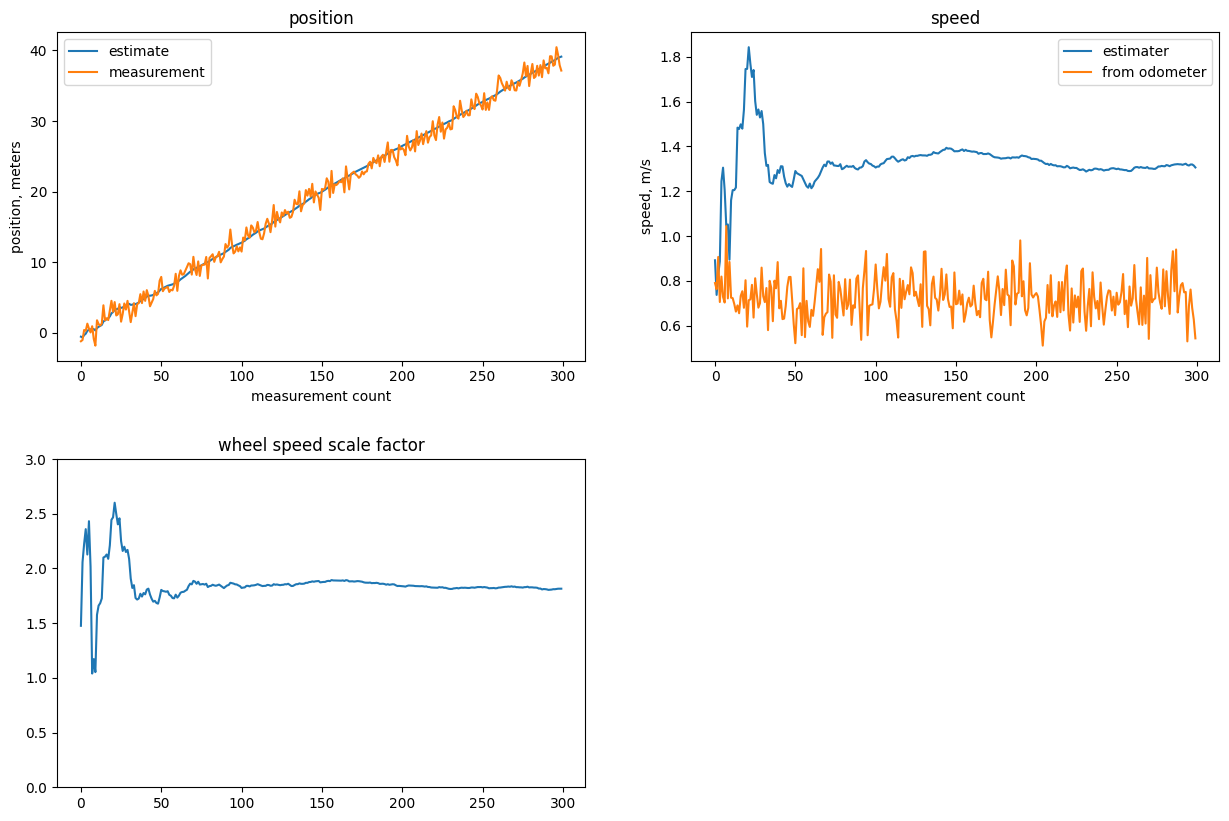

In [144]:
def fx(x, dt):
    # простейшая модель движения, p = p0 + v*dt, коэффициент одометра константа
    F = np.array([[1, dt, 0],
                  [0, 1, 0],
                  [0, 0, 1]], dtype=float)
    return np.dot(F, x)

def hx(x):
    # функция для конвертации из стейта в измерение
    return np.array([x[0], x[1]/x[2]])

# create sigma points to use in the filter. This is standard for Gaussian processes
points = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=-1)

# настоящая скорость
vel = 1.3
# устанавливаем уровень желаемого шума одометра
vel_std = 0.1
# уровень шума сенсора позиции
pos_std = 1.0
# число измерений
num = 300
# полное время
t = 30
# настоящий коэффициент одометра
wheel_speed_scale = 1.8 


dt = t/num # рассчитываем дельту времени
path_len = vel*t # считаем длину пройденного пути (нужно для генерации измерений)
z_pos = np.linspace(0, path_len, num) # правильные измерения координат
z_pos = [pos+randn()*pos_std for pos in z_pos] # зашумляем измерения координат

# генерируем шумные измерения скорости
z_vel = [vel/wheel_speed_scale + randn()*vel_std for i in range(num)]   

# создаем фильтр
kf = UnscentedKalmanFilter(dim_x=3, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)

# объявляем начальное состояние и начальную матрицу ковариаций
kf.x = np.array([0.0, 1.0, 1.0])
kf.P = np.diag([1.0**2, 1**2, 3.0**2])

# объявляем матрицу шумов процесса
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.001)
kf.Q[2,2] = 0.00001

xs = []

# симуляция эксперимента
for i in range(num):
    kf.predict()
    kf.dt = dt
    kf.R = np.diag([pos_std**2, vel_std**2])
    kf.hx = hx
    z_vector = [z_pos[i], z_vel[i]]
    kf.update(z_vector)
    xs.append(kf.x.copy())
    
xs = np.array(xs)
zs_pos = np.array(zs_pos)
plt.figure(figsize=(15,10), dpi=100)
plt.subplot(221)
plt.title("position")
plt.plot(xs[:,0], label="estimate")
plt.plot(z_pos, label="measurement")
plt.xlabel("measurement count")
plt.ylabel("position, meters")
plt.legend()
plt.subplot(222)
plt.title("speed")
plt.plot(xs[:,1], label="estimater")
plt.plot(z_vel, label="from odometer")
plt.xlabel("measurement count")
plt.ylabel("speed, m/s")
plt.legend()
plt.subplot(223)
plt.title("wheel speed scale factor")
plt.plot(xs[:,2])
plt.ylim(0,3)
plt.subplots_adjust(hspace=0.3)